## Data Wranglin'
#### Downloading, viewing, cleaning, processing data for modeling use

### Imports and settings

In [1]:
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.core.display import display
pd.set_option('display.max_columns', None)

2023-07-26 11:43:18.842194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 11:43:19.250700: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 11:43:20.173077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-07-26 11:43:20.173285: W tensorflow/compiler/xla/stream_exe

### Urls and local storage locations

In [7]:
COINBASE_loc = "data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv"
BITSTAMP_loc = "data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv"

COINBASE_url = 'https://drive.google.com/file/d/16MgiuBfQKzXPoWFWi2w-LKJuZ7LgivpE/view?usp=sharing'
BITSTAMP_url = 'https://drive.google.com/file/d/15A-rLSrfZ0td7muSrYHy0WX9ZqrMweES/view?usp=sharing'

### Preprocessing method for use prior to training

In [78]:
"""Time Series Forecasting of Bitcoin Prices using Keras"""


def preprocess_data(data_loc: str) -> pd.DataFrame:
    """converts raw data for use in time series forecasting"""
    
    #read in data
    df = pd.read_csv(data_loc)
    
    #grab only timestamp and weighted price
    df = df[['Timestamp', 'Weighted_Price']]
    
    #convert timestamp to datetime
    df['NewTimestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df['Weighted_Price_filled'] = df['Weighted_Price'].rolling(window=24,
                                                               min_periods=1).mean()
    df['Weighted_Price'].fillna(df['Weighted_Price_filled'], inplace=True)
    df.drop(['Weighted_Price_filled'], axis=1, inplace=True)
    
    #drop any remaining null values
    df.dropna(inplace=True)
    
    # remove data from before 2017
    mask = df['NewTimestamp'] >= pd.to_datetime(f'2017-01-01')
    df = df[mask]
    df.drop(['NewTimestamp'], axis=1, inplace=True)
    
    #split the data into train, val, and test sets
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    #normalize the data based off of the training set only (to prevent data leakage)
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    #time change to 1 hour
    train_df = train_df[0::60]
    val_df = val_df[0::60]
    test_df = test_df[0::60]
    
    
    return train_df, val_df, test_df


### df Objects

In [32]:
bit_train_df, bit_val_df, bit_test_df  = preprocess_data(BITSTAMP_loc)

/tmp/ipykernel_17502/330784552.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Weighted_Price'] = (train_df['Weighted_Price'] - train_df['Weighted_Price'].mean()) / train_df['Weighted_Price'].std()
/tmp/ipykernel_17502/330784552.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Weighted_Price'] = (val_df['Weighted_Price'] - train_mean) / train_std
/tmp/ipykernel_17502/330784552.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

### Checking for NaNs
#### (Not needed now)

In [5]:

total_rows_with_nan = coinDf.isnull().any(axis=1).sum()
print(coinDf.head())
print(total_rows_with_nan)
print(bitDf.shape)
print(coinDf.shape)


               Timestamp  Weighted_Price
0    2014-12-01 05:33:00      300.000000
82   2014-12-01 06:55:00      370.000000
1783 2014-12-02 11:16:00      377.994792
2317 2014-12-02 20:10:00      378.000000
2926 2014-12-03 06:19:00      378.000000
0
(67260, 2)
(34629, 2)


### Comparison Plots

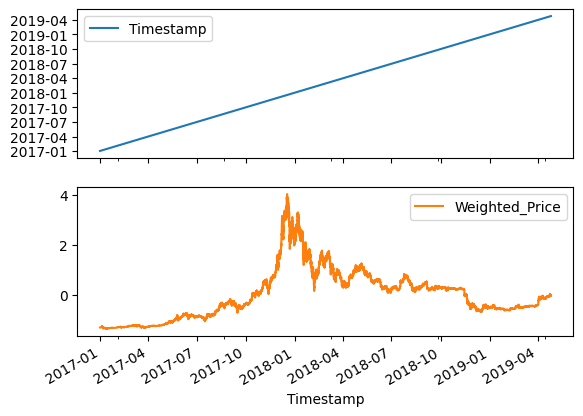

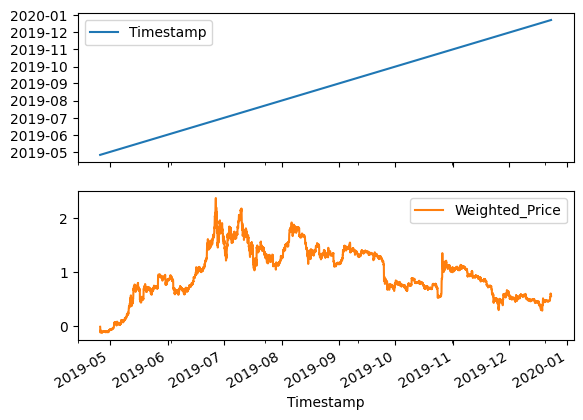

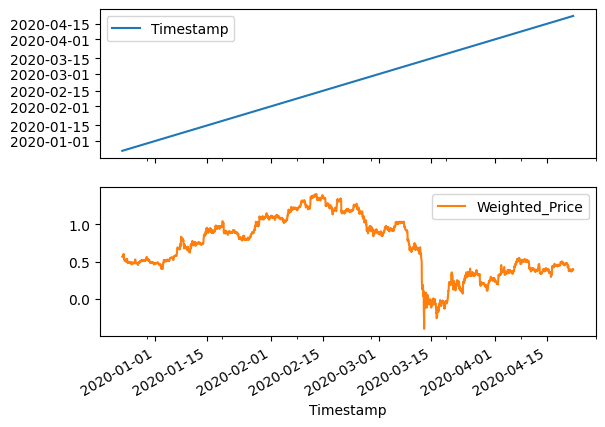

In [33]:
plot_cols = ['Timestamp', 'Weighted_Price']

# Training set plot
plot_features = bit_train_df[plot_cols]
plot_features.index = bit_train_df['Timestamp']
_ = plot_features.plot(subplots=True)

# Validation set plot
plot_features = bit_val_df[plot_cols]
plot_features.index = bit_val_df['Timestamp']
_ = plot_features.plot(subplots=True)

# Test set plot
plot_features = bit_test_df[plot_cols]
plot_features.index = bit_test_df['Timestamp']
_ = plot_features.plot(subplots=True)
# plot_features = coinDf[plot_cols]
# plot_features.index = coinDf['Timestamp']
# _ = plot_features.plot(subplots=True)

## Model Building
#### RNN Architecture based on TF/Keras documentation example

In [77]:
print(train_df.head())

          Timestamp  Weighted_Price
2625376  1483228800       -1.292279
2625436  1483232400       -1.291875
2625496  1483236000       -1.292515
2625556  1483239600       -1.292748
2625616  1483243200       -1.293580


In [82]:
train_df, val_df, test_df  = preprocess_data(BITSTAMP_loc)
print(train_df.head())

         Timestamp  Weighted_Price
2625376  -1.732046       -1.292279
2625436  -1.731875       -1.291875
2625496  -1.731704       -1.292515
2625556  -1.731534       -1.292748
2625616  -1.731363       -1.293580


In [83]:
"""Window Generator Class"""


class WindowGenerator():
    """defines the window size and shift for the time series data"""
    def __init__(self, input_width, label_width, shift, train_df=train_df,
                 val_df=val_df, test_df=test_df, label_columns=None):
        """decorator for the class"""
        # raw data from the processed data frame
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # column indices of the data frame
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='Weighted_Price', max_subplots=2):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        if label_col_index is None:
            continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result
WindowGenerator.example = example
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [90]:
training_window = WindowGenerator(input_width=24, label_width=24, shift=1,
                                  label_columns=['Weighted_Price'])

In [85]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()]
                  )

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

### Baseline work

In [86]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1,
                                     label_columns=['Weighted_Price'])

In [87]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]
    

baseline = Baseline(label_index=single_step_window.column_indices['Weighted_Price'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

182/182 [==============================] - 1s 2ms/step - loss: 5.4927e-04 - mean_absolute_error: 0.0128


### Real attempt with LTSM

In [91]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, return_sequences=True),
    tf.keras.layers.Dense(units=1)])

history = compile_and_fit(lstm_model, training_window)

Epoch 1/20
633/633 [==============================] - 14s 17ms/step - loss: 0.0944 - mean_absolute_error: 0.1384 - val_loss: 0.0425 - val_mean_absolute_error: 0.1069
Epoch 2/20
633/633 [==============================] - 10s 16ms/step - loss: 0.0108 - mean_absolute_error: 0.0406 - val_loss: 0.0251 - val_mean_absolute_error: 0.0777
Epoch 3/20
633/633 [==============================] - 10s 16ms/step - loss: 0.0032 - mean_absolute_error: 0.0241 - val_loss: 0.0205 - val_mean_absolute_error: 0.0652
Epoch 4/20
633/633 [==============================] - 10s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0171 - val_loss: 0.0167 - val_mean_absolute_error: 0.0563
Epoch 5/20
633/633 [==============================] - 10s 16ms/step - loss: 8.2893e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0134 - val_mean_absolute_error: 0.0498
Epoch 6/20
633/633 [==============================] - 11s 17ms/step - loss: 7.6110e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0108 - val_mean_absolute_error: 0.0

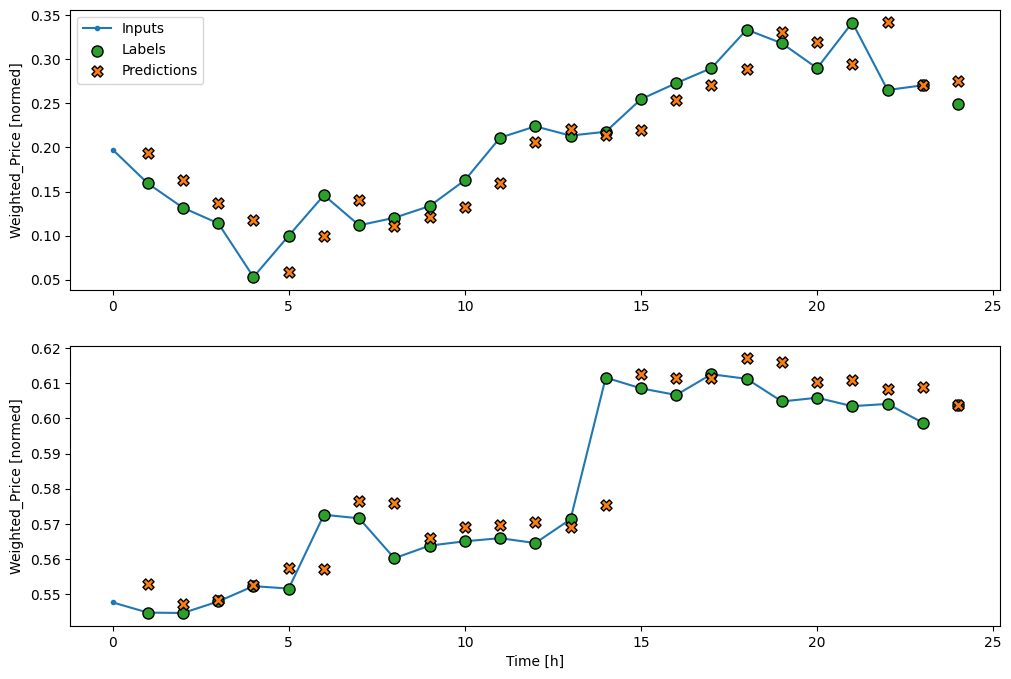

In [92]:
training_window.plot(lstm_model)